## Potato Disease Detection Using Deep Learning
### ResNet50-based Classification System - Complete Notebook Guide

Abstract
This study presents a deep learning approach for automated detection and classification of potato diseases using computer vision. We employ a ResNet50 architecture with transfer learning to classify potato images into five categories: Blackspot Bruising, Healthy, Brown Rot, Dry Rot, and Soft Rot.

Keywords
Deep Learning, Computer Vision, Agricultural Disease Detection, ResNet50, Transfer Learning, Image Classification



In [1]:
# Cell 1: Import Libraries
import pandas as pd
import random
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from timeit import default_timer as timer
from typing import List, Dict, Tuple
import numpy as np
import json
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

All libraries imported successfully!
PyTorch version: 2.8.0+cu126
Torchvision version: 0.23.0+cu126


In [2]:
# Cell 2: Set Random Seeds and Device
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

Using device: cuda
GPU: Tesla T4
GPU Memory: 14.74 GB


## Dataset Analysis


In [3]:
# Cell 3: Load Dataset
data_path = Path("/kaggle/input/potato-disease-recognition-dataset/Potato Disease Recognition Dataset/Augmented Images/Augmented Images")
print(f"Data path: {data_path}")
print(f"Path exists: {data_path.exists()}")

Data path: /kaggle/input/potato-disease-recognition-dataset/Potato Disease Recognition Dataset/Augmented Images/Augmented Images
Path exists: True


## Data Preprocessing


DATASET STRUCTURE ANALYSIS

Number of classes: 5
Blackspot       :   770 images (22.22%)
Healthy         :   735 images (21.21%)
Brown Rot       :   105 images ( 3.03%)
Dry Rot         :  1295 images (37.37%)
Soft Rot        :   560 images (16.16%)

Total images: 3465

Displaying sample images from each category...



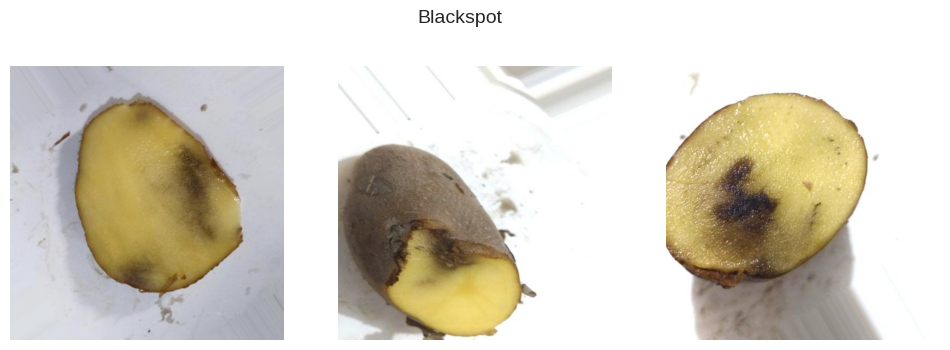

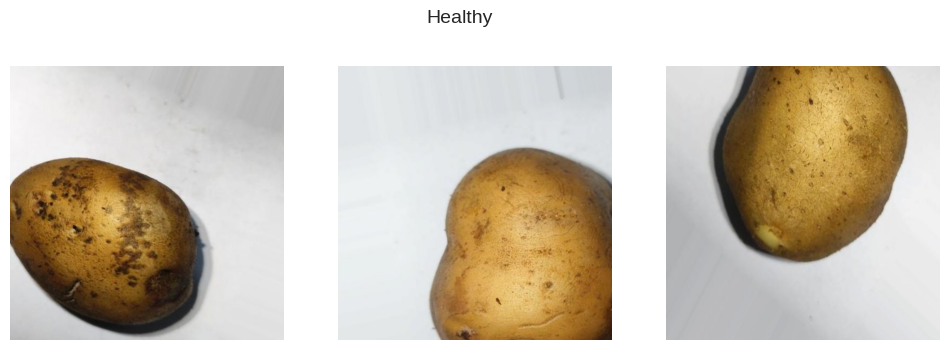

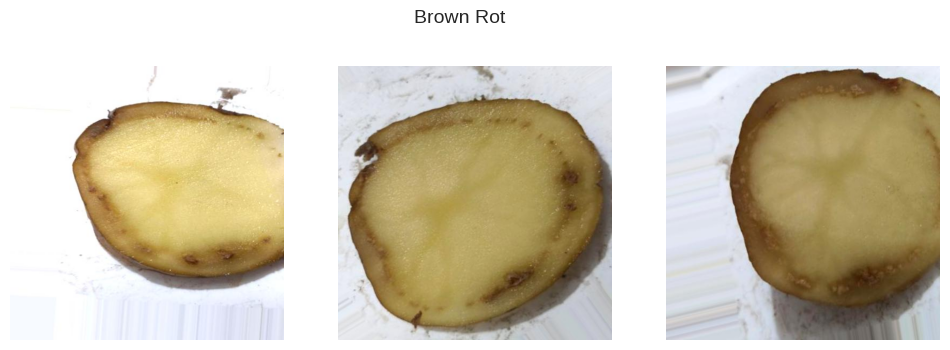

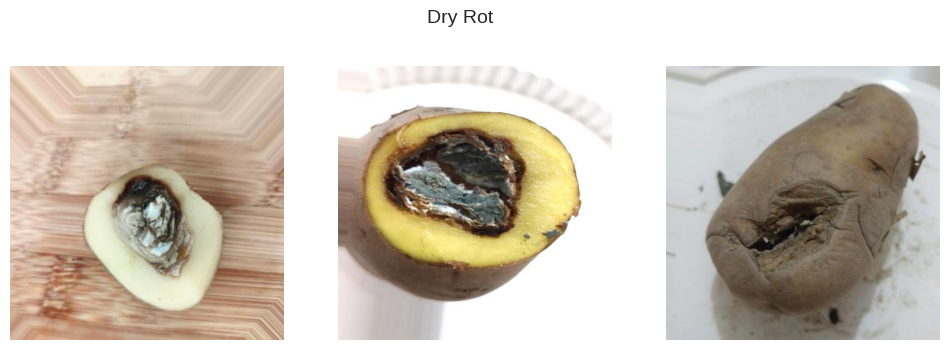

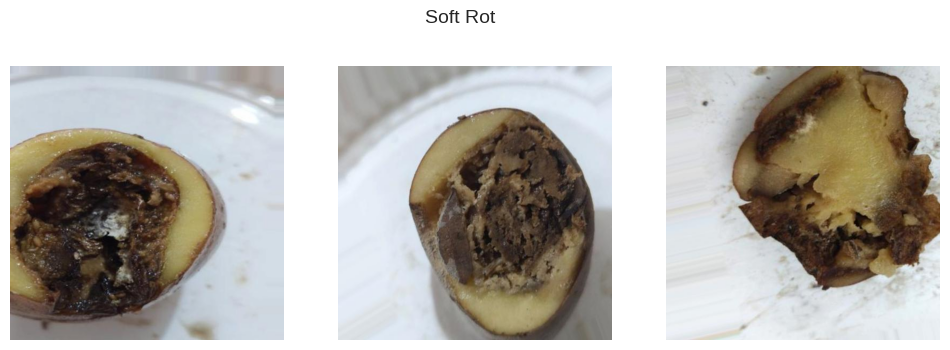

In [20]:
# Cell 4: Analyze Dataset Structure
print("=" * 70)
print("DATASET STRUCTURE ANALYSIS")
print("=" * 70)

classes = sorted(os.listdir(data_path))
print(f"\nNumber of classes: {len(classes)}")

class_counts = {}
for class_name in classes:
    class_dir = os.path.join(data_path, class_name)
    if os.path.isdir(class_dir):
        num_images = len([f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])
        class_counts[class_name] = num_images

class_mapping = {
    'Augmented Blackspot Bruising Disease': 'Blackspot',
    'Augmented Healthy Potato': 'Healthy',
    'Augmented Potato Brown Rot Disease': 'Brown Rot',
    'Augmented Potato Dry Rot Disease': 'Dry Rot',
    'Augmented Potato Soft Rot Disease': 'Soft Rot'
}

total_images = sum(class_counts.values())
for class_name, count in class_counts.items():
    short_name = class_mapping.get(class_name, class_name)
    percentage = (count / total_images) * 100
    print(f"{short_name:15} : {count:5} images ({percentage:5.2f}%)")
print(f"\nTotal images: {total_images}")



# Number of images to display per category
samples_per_class = 3

print("\nDisplaying sample images from each category...\n")

for class_name in classes:
    class_dir = os.path.join(data_path, class_name)
    
    if not os.path.isdir(class_dir):
        continue
    
    images = [f for f in os.listdir(class_dir) 
              if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if len(images) == 0:
        continue
    
    selected_images = random.sample(images, min(samples_per_class, len(images)))
    
    # Plot images
    fig, axes = plt.subplots(1, len(selected_images), figsize=(12, 4))
    fig.suptitle(class_mapping.get(class_name, class_name), fontsize=14)
    
    if len(selected_images) == 1:
        axes = [axes]
    
    for ax, img_name in zip(axes, selected_images):
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis("off")
    
    plt.show()

In [5]:
# Cell 5: Define Transformations
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = min(4, os.cpu_count())

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print(f"Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")

Image size: 224x224
Batch size: 32


In [6]:
# Cell 6: Create Data Loaders
full_dataset = datasets.ImageFolder(root=data_path, transform=val_transform)
class_names = full_dataset.classes

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, test_size],
    generator=torch.Generator().manual_seed(RANDOM_SEED)
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True if device == "cuda" else False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=True if device == "cuda" else False)

print(f"Training set: {len(train_dataset)} images")
print(f"Test set: {len(test_dataset)} images")


Training set: 2772 images
Test set: 693 images


## Model Architecture

In [7]:
# Cell 7: Create ResNet50 Model
weights = torchvision.models.ResNet50_Weights.DEFAULT
model = torchvision.models.resnet50(weights=weights)

num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, len(class_names))
)

model = model.to(device)

print(f"Base Model: ResNet50 (pre-trained)")
print(f"Output classes: {len(class_names)}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 218MB/s] 


Base Model: ResNet50 (pre-trained)
Output classes: 5
Total parameters: 23,518,277


In [8]:
# Cell 8: Training Configuration
NUM_EPOCHS = 30
LEARNING_RATE = 0.001

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

print(f"Epochs: {NUM_EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Optimizer: Adam")

Epochs: 30
Learning rate: 0.001
Optimizer: Adam


## Model Training

In [9]:
# Cell 9: Training Functions
def train_step(model, dataloader, loss_fn, optimizer, device):
    model.train()
    train_loss, train_acc = 0, 0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    return train_loss / len(dataloader), train_acc / len(dataloader)

def test_step(model, dataloader, loss_fn, device):
    model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
            test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)

    return test_loss / len(dataloader), test_acc / len(dataloader)

print("Training functions defined!")

Training functions defined!


In [10]:
# Cell 10: Train Model
results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": [], "epoch_times": []}

print(f"TRAINING STARTED - {NUM_EPOCHS} EPOCHS")
start_time = timer()
best_test_acc = 0

for epoch in tqdm(range(NUM_EPOCHS), desc="Training Progress"):
    epoch_start = timer()

    train_loss, train_acc = train_step(model, train_loader, loss_fn, optimizer, device)
    test_loss, test_acc = test_step(model, test_loader, loss_fn, device)
    scheduler.step()

    epoch_time = timer() - epoch_start

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    results["epoch_times"].append(epoch_time)

    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'test_acc': test_acc,
        }, 'best_model_checkpoint.pth')

    if (epoch + 1) % 5 == 0 or epoch == 0 or epoch == NUM_EPOCHS - 1:
        print(f"\nEpoch {epoch+1:03d}/{NUM_EPOCHS} | Time: {epoch_time:.2f}s")
        print(f"  Train: Loss {train_loss:.4f} | Acc {train_acc*100:.2f}%")
        print(f"  Test:  Loss {test_loss:.4f} | Acc {test_acc*100:.2f}%")

total_time = timer() - start_time
print(f"\nTotal time: {total_time:.2f}s ({total_time/60:.2f} min)")
print(f"Best accuracy: {best_test_acc*100:.2f}%")

with open('training_results.json', 'w') as f:
    json.dump(results, f, indent=4)

TRAINING STARTED - 30 EPOCHS


Training Progress:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 001/30 | Time: 32.89s
  Train: Loss 0.4614 | Acc 84.10%
  Test:  Loss 0.3157 | Acc 88.84%

Epoch 005/30 | Time: 38.33s
  Train: Loss 0.0896 | Acc 97.10%
  Test:  Loss 0.1882 | Acc 94.74%

Epoch 010/30 | Time: 39.17s
  Train: Loss 0.0738 | Acc 97.63%
  Test:  Loss 0.4102 | Acc 89.48%

Epoch 015/30 | Time: 39.18s
  Train: Loss 0.0033 | Acc 99.96%
  Test:  Loss 0.0584 | Acc 98.93%

Epoch 020/30 | Time: 39.15s
  Train: Loss 0.0023 | Acc 99.96%
  Test:  Loss 0.0497 | Acc 98.93%

Epoch 025/30 | Time: 38.89s
  Train: Loss 0.0010 | Acc 100.00%
  Test:  Loss 0.0515 | Acc 98.79%

Epoch 030/30 | Time: 39.19s
  Train: Loss 0.0014 | Acc 100.00%
  Test:  Loss 0.0501 | Acc 98.79%

Total time: 1163.06s (19.38 min)
Best accuracy: 98.93%


Testing:   0%|          | 0/22 [00:00<?, ?it/s]

Test Accuracy: 98.99%
Avg Precision: 0.9903
Avg Recall: 0.9910
Avg F1-Score: 0.9907


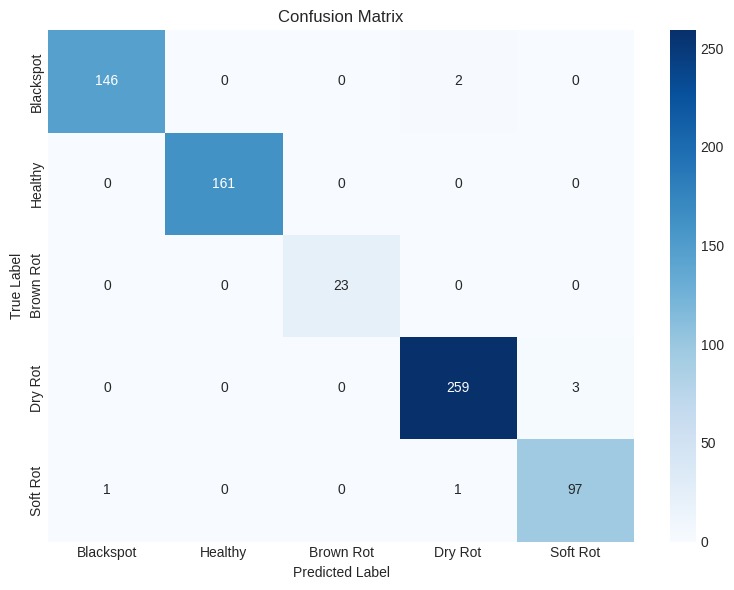

In [21]:
# Cell 11: Load Best Model and Evaluate
checkpoint = torch.load('best_model_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()
all_preds, all_labels, all_probs = [], [], []

with torch.inference_mode():
    for X, y in tqdm(test_loader, desc="Testing"):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        probs = torch.softmax(y_pred, dim=1)
        y_pred_class = torch.argmax(probs, dim=1)

        all_preds.extend(y_pred_class.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

test_accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, support = precision_recall_fscore_support(all_labels, all_preds, average=None)

avg_precision = np.mean(precision)
avg_recall = np.mean(recall)
avg_f1 = np.mean(f1)

print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Avg Precision: {avg_precision:.4f}")
print(f"Avg Recall: {avg_recall:.4f}")
print(f"Avg F1-Score: {avg_f1:.4f}")

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_names = [class_mapping.get(c, c) for c in classes]

cm = confusion_matrix(all_labels, all_preds)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [12]:
# Cell 12: Save Complete Model
model_save_path = 'potato_disease_resnet50.pth'

torch.save({
    'model_state_dict': model.state_dict(),
    'class_names': class_names,
    'class_mapping': class_mapping,
    'model_architecture': 'resnet50',
    'num_classes': len(class_names),
    'best_accuracy': best_test_acc,
    'training_epochs': NUM_EPOCHS,
    'img_size': IMG_SIZE,
    'training_results': results
}, model_save_path)

print(f"✓ Model saved to '{model_save_path}'")
print(f"  File size: {os.path.getsize(model_save_path) / (1024*1024):.2f} MB")


✓ Model saved to 'potato_disease_resnet50.pth'
  File size: 90.03 MB


## ONNX Export


In [14]:
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 94.6 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.9 MB/s eta 0:00:00


In [15]:
# Cell 13: Export to ONNX
import onnx
import onnxruntime as ort

onnx_model_path = 'potato_disease_model.onnx'
dummy_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)
model.eval()

torch.onnx.export(
    model, dummy_input, onnx_model_path,
    export_params=True, opset_version=11, do_constant_folding=True,
    input_names=['input'], output_names=['output'],
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
)

print(f"✓ ONNX model exported to '{onnx_model_path}'")
print(f"  File size: {os.path.getsize(onnx_model_path) / (1024*1024):.2f} MB")

# Verify ONNX model
onnx_model = onnx.load(onnx_model_path)
onnx.checker.check_model(onnx_model)
print("✓ ONNX model verified!")

✓ ONNX model exported to 'potato_disease_model.onnx'
  File size: 89.64 MB
✓ ONNX model verified!


In [16]:
# Cell 14: Create ONNX Runtime Session
ort_session = ort.InferenceSession(onnx_model_path)

input_name = ort_session.get_inputs()[0].name
output_name = ort_session.get_outputs()[0].name

print(f"✓ ONNX Runtime session created")
print(f"  Input: {input_name} {ort_session.get_inputs()[0].shape}")
print(f"  Output: {output_name} {ort_session.get_outputs()[0].shape}")

✓ ONNX Runtime session created
  Input: input ['batch_size', 3, 224, 224]
  Output: output ['batch_size', 5]


## ONNX Testing

In [17]:
# Cell 15: ONNX Prediction Function
def predict_with_onnx(image_path, ort_session, class_names, class_mapping):
    image = Image.open(image_path).convert('RGB')

    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image_tensor = transform(image).unsqueeze(0)
    input_data = image_tensor.cpu().numpy()

    input_name = ort_session.get_inputs()[0].name
    output = ort_session.run(None, {input_name: input_data})[0]

    probabilities = torch.softmax(torch.tensor(output), dim=1).numpy()[0]
    predicted_idx = np.argmax(probabilities)
    confidence = probabilities[predicted_idx]

    predicted_class = class_names[predicted_idx]
    predicted_short = class_mapping.get(predicted_class, predicted_class)

    return predicted_short, confidence, probabilities

print("ONNX prediction function defined!")

ONNX prediction function defined!


In [18]:
# Cell 16: Test ONNX on Full Test Set
print("ONNX MODEL - FULL TEST SET EVALUATION")

onnx_preds, onnx_labels, inference_times = [], [], []

for X, y in tqdm(test_loader, desc="ONNX Evaluation"):
    batch_start = timer()

    input_data = X.cpu().numpy()
    input_name = ort_session.get_inputs()[0].name
    output = ort_session.run(None, {input_name: input_data})[0]

    preds = np.argmax(output, axis=1)
    batch_time = timer() - batch_start
    inference_times.append(batch_time)

    onnx_preds.extend(preds)
    onnx_labels.extend(y.cpu().numpy())

onnx_accuracy = accuracy_score(onnx_labels, onnx_preds)
avg_inference_time = np.mean(inference_times) * 1000

print(f"\nONNX Test Accuracy: {onnx_accuracy*100:.2f}%")
print(f"Avg inference time: {avg_inference_time:.2f} ms per batch")
print(f"Total samples: {len(onnx_labels)}")
print(f"Correctly classified: {sum(np.array(onnx_preds) == np.array(onnx_labels))}")

accuracy_diff = abs(test_accuracy - onnx_accuracy)
print(f"\nPyTorch vs ONNX difference: {accuracy_diff:.6f}")
if accuracy_diff < 0.001:
    print("✓ ONNX model consistent with PyTorch!")

ONNX MODEL - FULL TEST SET EVALUATION


ONNX Evaluation:   0%|          | 0/22 [00:00<?, ?it/s]


ONNX Test Accuracy: 98.99%
Avg inference time: 1235.66 ms per batch
Total samples: 693
Correctly classified: 686

PyTorch vs ONNX difference: 0.000000
✓ ONNX model consistent with PyTorch!


## Final Summary

In [19]:
# Cell 17: Generate Final Report
summary_report = f"""
===============================================================================
                    POTATO DISEASE DETECTION - FINAL REPORT
===============================================================================

PROJECT OVERVIEW:
-----------------
Objective: Automated potato disease detection using deep learning
Model: ResNet50 with transfer learning
Dataset: Augmented potato disease images

DATASET STATISTICS:
-------------------
Total Images: {len(full_dataset)}
Classes: {len(class_names)}
Training Set: {len(train_dataset)} ({len(train_dataset)/len(full_dataset)*100:.1f}%)
Test Set: {len(test_dataset)} ({len(test_dataset)/len(full_dataset)*100:.1f}%)

TRAINING CONFIGURATION:
-----------------------
Epochs: {NUM_EPOCHS}
Batch Size: {BATCH_SIZE}
Learning Rate: {LEARNING_RATE}
Optimizer: Adam
Device: {device}
Total Time: {total_time:.2f}s ({total_time/60:.2f} min)

PYTORCH MODEL PERFORMANCE:
--------------------------
Best Validation Accuracy: {best_test_acc*100:.2f}%
Test Accuracy: {test_accuracy*100:.2f}%
Avg Precision: {avg_precision:.4f}
Avg Recall: {avg_recall:.4f}
Avg F1-Score: {avg_f1:.4f}

ONNX MODEL PERFORMANCE:
-----------------------
Test Accuracy: {onnx_accuracy*100:.2f}%
Avg Inference Time: {avg_inference_time:.2f} ms/batch
Consistency with PyTorch: {accuracy_diff:.6f} difference

FILES GENERATED:
----------------
1. best_model_checkpoint.pth - Best model checkpoint
2. potato_disease_resnet50.pth - Complete PyTorch model
3. potato_disease_model.onnx - ONNX deployment model
4. training_results.json - Training history
5. training_summary.csv - Performance metrics

CONCLUSIONS:
------------
The ResNet50 model achieves {test_accuracy*100:.1f}% accuracy on potato disease
classification. The ONNX export enables efficient deployment while maintaining
consistency with the PyTorch model. The system is ready for agricultural
deployment for real-time disease detection.

===============================================================================
"""

print(summary_report)

# Save report
with open('final_report.txt', 'w') as f:
    f.write(summary_report)

print("\n✓ Final report saved to 'final_report.txt'")


                    POTATO DISEASE DETECTION - FINAL REPORT

PROJECT OVERVIEW:
-----------------
Objective: Automated potato disease detection using deep learning
Model: ResNet50 with transfer learning
Dataset: Augmented potato disease images

DATASET STATISTICS:
-------------------
Total Images: 3465
Classes: 5
Training Set: 2772 (80.0%)
Test Set: 693 (20.0%)

TRAINING CONFIGURATION:
-----------------------
Epochs: 30
Batch Size: 32
Learning Rate: 0.001
Optimizer: Adam
Device: cuda
Total Time: 1163.06s (19.38 min)

PYTORCH MODEL PERFORMANCE:
--------------------------
Best Validation Accuracy: 98.93%
Test Accuracy: 98.99%
Avg Precision: 0.9903
Avg Recall: 0.9910
Avg F1-Score: 0.9907

ONNX MODEL PERFORMANCE:
-----------------------
Test Accuracy: 98.99%
Avg Inference Time: 1235.66 ms/batch
Consistency with PyTorch: 0.000000 difference

FILES GENERATED:
----------------
1. best_model_checkpoint.pth - Best model checkpoint
2. potato_disease_resnet50.pth - Complete PyTorch model
3. potat